# Dense Neural Network for Text Classification

## Preliminaries

### Imports

In [1]:
import os
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
import tensorflow.keras as keras


%matplotlib inline

import sys
sys.path.append("../..")

from E4525_ML import text
from E4525_ML import plots
from E4525_ML.notebook_utils import get_logger,LoggingCallback


In [2]:
tf.__version__

'1.13.1'

In [3]:
logger=get_logger()

In [4]:
seed=456
np.random.seed(seed)

### Data Processing

In [5]:
reviews_filename="../../raw/amazon-reviews/Reviews.csv"

In [6]:
data=pd.read_csv(reviews_filename)

In [7]:
data_dir=r"../../data/amazon-reviews"

### Split into Train, Validation and Test Sets

In [8]:
documents_all=data["Text"].as_matrix()
labels_all=data["Score"].as_matrix()
print(documents_all.shape)

(568454,)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [9]:
docs,docs_test,labels,labels_test=train_test_split(documents_all,labels_all,test_size=0.1)
print(docs.shape,docs_test.shape)

(511608,) (56846,)


In [10]:
docs_train,docs_val,labels_train,labels_val=train_test_split(docs,labels,test_size=0.05)
print(docs_train.shape,docs_val.shape)

(486027,) (25581,)


### Text Embedding Pipeline

In [11]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Manel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
countVectorizer=TfidfVectorizer(input="content",decode_error="ignore",
                                       max_features=50000,
                                       #tokenizer=text.stem_tokenizer,
                                       #stop_words=text.stop_words()
                               )
dencoder=text.DocumentEncoder(countVectorizer)


In [50]:
pickle_filename=data_dir+"/amazon_reviews.p"
if True: 
    texts_train=dencoder.fit_transform(docs_train)
    texts_val=dencoder.transform(docs_val)
    texts_test=dencoder.transform(docs_test)
    
    file=open(pickle_filename,"wb")
    pickle.dump((countVectorizer,texts_train,labels_train,texts_val,labels_val,texts_test,labels_test),file)
    file.close()
else:
    file=open(pickle_filename,"rb")
    countVectorizer,texts_train,labels_train,texts_val,labels_val,texts_test,labels_test=pickle.load(file)
    file.close()
print(texts_train.shape,texts_val.shape,texts_test.shape)

(486027,) (25581,) (56846,)


In [51]:
ltexts=[len(text) for text in texts_train]

(array([ 66793., 159835.,  94500.,  56948.,  34429.,  22415.,  14285.,
          9634.,   6959.,   4860.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <a list of 10 Patch objects>)

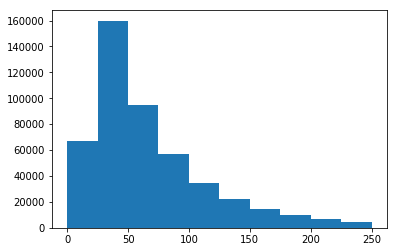

In [52]:
plt.hist(ltexts,range=[0,250])

In [53]:
def pad_texts(texts,W):
    fragments=[]
    fragment_labels=[]
    for idx,text in enumerate(texts):
            fragment=text[0:W]
            fragment=np.pad(fragment,(W-len(fragment),0),mode="constant",constant_values=-2)
            fragments.append(fragment)
    return np.array(fragments)

In [54]:
W=125

In [55]:
X_train=pad_texts(texts_train,W)
Y_train=labels_train>3
print(X_train.shape,Y_train.shape)

(486027, 125) (486027,)


In [56]:
X_val=pad_texts(texts_val,W)
Y_val=labels_val>3
print(X_val.shape,Y_val.shape)

(25581, 125) (25581,)


In [57]:

X_test=pad_texts(texts_test,W)
Y_test=labels_test>3
print(X_test.shape,Y_test.shape)

(56846, 125) (56846,)


In [58]:
X_train[0]

array([-2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00,
       -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00,
       -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00,
       -2.0000e+00, -2.0000e+00, -2.0000e+00, -2.0000e+00,  4.4839e+04,
        1.0765e+04,  4.8210e+04,  3.5747e+04,  2.3155e+04,  4.4669e+04,
        3.2617e+04,  6.2360e+03,  1.8644e+04,  2.9720e+04,  2.2655e+04,
        1.5654e+04,  4.5233e+04,  1.0317e+04,  6.5730e+03,  2.9720e+04,
        1.1753e+04,  3.0350e+04,  2.6865e+04,  3.0000e+04,  2.4270e+04,
        2.0997e+04,  8.7540e+03,  2.7641e+04,  4.3350e+03,  4.0171e+04,
        2.3155e+04,  4.4669e+04,  3.2617e+04,  2.2284e+04,  4.4656e+04,
        4.9292e+04,  6.0480e+03,  1.8440e+03,  4.5233e+04,  4.2263e+04,
        4.4695e+04,  4.7108e+04,  2.5500e+03,  2.3155e+04,  4.4669e+04,
        1.9348e+04,  8.3380e+03,  4.6697e+04,  4.4656e+04,  4.8229e+04,
        4.4669e+04,  9.1410e+03,  1.6973e+04,  8.7540e+03,  4.46

In [59]:
X_train.max(),X_train.min()

(49999.0, -2.0)

In [60]:
num_classes = 2
V=len(countVectorizer.vocabulary_)+2 # one for unknown words, one for padding
print(num_classes,V)

2 50002


## Recurrent Neural Network Model

In [61]:
 def build_model(W,V,E,hidden1,hidden2,dropout):
    model=keras.Sequential(
        [ keras.layers.Lambda(lambda x: x+2,input_shape=(W,)), # add two to handle padding and unknown words
          keras.layers.Embedding(V,E,input_length=W),
         keras.layers.CuDNNLSTM(hidden1,return_sequences=True),
         keras.layers.CuDNNLSTM(hidden2),
         keras.layers.Dropout(dropout),
         #keras.layers.Flatten(),
         keras.layers.Dense(2,activation="softmax")
        ])
    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001),loss="sparse_categorical_crossentropy",metrics=["accuracy"]) 
    return model

In [62]:
N=X_train.shape[0]
D=X_train.shape[1]
K=num_classes
print(N,D,E,K)

486027 125 8 2


In [86]:
droput=0.4
E=10
hidden1=16
hidden2=16

In [87]:
W,V,E,hidden1,hidden2,droput

(125, 50002, 10, 16, 16, 0.4)

In [88]:
model0=build_model(W,V,E,hidden1,hidden2,droput)
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_36 (Lambda)           (None, 125)               0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 125, 10)           500020    
_________________________________________________________________
cu_dnnlstm_70 (CuDNNLSTM)    (None, 125, 16)           1792      
_________________________________________________________________
cu_dnnlstm_71 (CuDNNLSTM)    (None, 16)                2176      
_________________________________________________________________
dropout_35 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 34        
Total params: 504,022
Trainable params: 504,022
Non-trainable params: 0
_________________________________________________________________


In [89]:
nepochs=5

In [90]:
model0.fit(X_train,Y_train,validation_data=(X_val,Y_val),
            callbacks=[LoggingCallback(1,logger)],
           verbose=0,epochs=nepochs,batch_size=128)

2019-04-11 04:31:38,137|	0: TRAIN loss 0.2774,  acc 0.8873  ||  VAL loss 0.2395, acc 0.8990
2019-04-11 04:32:49,088|	1: TRAIN loss 0.2080,  acc 0.9194  ||  VAL loss 0.2004, acc 0.9199
2019-04-11 04:34:00,862|	2: TRAIN loss 0.1709,  acc 0.9356  ||  VAL loss 0.1852, acc 0.9277
2019-04-11 04:35:12,584|	3: TRAIN loss 0.1464,  acc 0.9455  ||  VAL loss 0.1927, acc 0.9307
2019-04-11 04:36:24,222|	4: TRAIN loss 0.1297,  acc 0.9522  ||  VAL loss 0.1919, acc 0.9256


In [91]:
Y_pred=np.argmax(model0.predict(X_val),axis=1)
np.mean(Y_pred==Y_val)

0.9255697588053634

## Hyperparameter Search

Now we perform layer size optimization

In [92]:
results=[]
for E in [10,50,200]:
    for hidden1 in [8,32,256]:
        for hidden2 in [8,32,256]:
        # Build the Recurrent Network
            model=build_model(W,V,E,hidden1,hidden2,droput)
            model.fit(X_train,Y_train,validation_data=(X_val,Y_val),
                  callbacks=[LoggingCallback(1,logger)],verbose=0,
                  epochs=nepochs,batch_size=128)
            Y_pred=np.argmax(model.predict(X_train),axis=1)
            acc_train=np.mean(Y_pred==Y_train)
            Y_pred=np.argmax(model.predict(X_val),axis=1)
            acc_val=np.mean(Y_pred==Y_val)
            print(E,hidden1,hidden2,acc_train,acc_val)
            results.append((E,hidden1,hidden2,acc_train,acc_val))
        

2019-04-11 04:37:49,322|	0: TRAIN loss 0.2859,  acc 0.8854  ||  VAL loss 0.2333, acc 0.9051
2019-04-11 04:39:01,377|	1: TRAIN loss 0.2176,  acc 0.9157  ||  VAL loss 0.2165, acc 0.9110
2019-04-11 04:40:13,811|	2: TRAIN loss 0.1879,  acc 0.9277  ||  VAL loss 0.2200, acc 0.9102
2019-04-11 04:41:26,221|	3: TRAIN loss 0.1637,  acc 0.9381  ||  VAL loss 0.2001, acc 0.9211
2019-04-11 04:42:38,762|	4: TRAIN loss 0.1442,  acc 0.9466  ||  VAL loss 0.2223, acc 0.9235
10 8 8 0.9554284021258078 0.923497908604042
2019-04-11 04:46:07,933|	0: TRAIN loss 0.2721,  acc 0.8894  ||  VAL loss 0.2342, acc 0.9045
2019-04-11 04:47:20,044|	1: TRAIN loss 0.2049,  acc 0.9201  ||  VAL loss 0.2093, acc 0.9174
2019-04-11 04:48:32,497|	2: TRAIN loss 0.1718,  acc 0.9346  ||  VAL loss 0.2059, acc 0.9213
2019-04-11 04:49:45,015|	3: TRAIN loss 0.1484,  acc 0.9442  ||  VAL loss 0.1907, acc 0.9277
2019-04-11 04:50:57,519|	4: TRAIN loss 0.1310,  acc 0.9515  ||  VAL loss 0.1926, acc 0.9306
10 8 32 0.9626728556232472 0.9305734

2019-04-11 07:59:03,405|	1: TRAIN loss 0.1693,  acc 0.9359  ||  VAL loss 0.1747, acc 0.9318
2019-04-11 08:01:22,108|	2: TRAIN loss 0.1352,  acc 0.9500  ||  VAL loss 0.1732, acc 0.9353
2019-04-11 08:03:40,854|	3: TRAIN loss 0.1087,  acc 0.9605  ||  VAL loss 0.1833, acc 0.9339
2019-04-11 08:05:59,226|	4: TRAIN loss 0.0876,  acc 0.9685  ||  VAL loss 0.1972, acc 0.9366
50 256 32 0.9790196840916245 0.9366326570501544
2019-04-11 08:12:18,895|	0: TRAIN loss 0.2545,  acc 0.8965  ||  VAL loss 0.1989, acc 0.9201
2019-04-11 08:15:50,804|	1: TRAIN loss 0.1692,  acc 0.9352  ||  VAL loss 0.1768, acc 0.9315
2019-04-11 08:19:22,393|	2: TRAIN loss 0.1341,  acc 0.9498  ||  VAL loss 0.1756, acc 0.9382
2019-04-11 08:22:54,034|	3: TRAIN loss 0.1084,  acc 0.9604  ||  VAL loss 0.1731, acc 0.9383
2019-04-11 08:26:25,183|	4: TRAIN loss 0.0868,  acc 0.9689  ||  VAL loss 0.1931, acc 0.9376
50 256 256 0.979564921290381 0.9376490363941988
2019-04-11 08:31:24,230|	0: TRAIN loss 0.2490,  acc 0.9032  ||  VAL loss 0.1

In [93]:
import pandas as pd

In [99]:
data=pd.DataFrame(results,columns=["E","hidden1","hidden2","train","valuation"])
data.head()

,E,hidden1,hidden2,train,valuation
0,10,8,8,0.955428,0.923498
1,10,8,32,0.962673,0.930573
2,10,8,256,0.956969,0.925961
3,10,32,8,0.965642,0.931785
4,10,32,32,0.964531,0.931668


In [101]:
data.to_csv(data_dir+"/RNN_Text_AmazonReviews.csv")
val_error=data[["E","hidden1","hidden2","valuation"]]

In [102]:
data["valuation"].max()

0.9401508932410774

In [103]:
best=data.iloc[data["valuation"].argmax()]
best

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


E            200.000000
hidden1      256.000000
hidden2        8.000000
train          0.986600
valuation      0.940151
Name: 24, dtype: float64

The best model achieves 83.3% accuracy using a 300 dimensional embedding, and two LSTM layers of size 256 units

## Test of best model

In [104]:
best_E=int(best["E"])
best_hidden1=int(best["hidden1"])
best_hidden2=int(best["hidden2"])

In [105]:
X=np.concatenate([X_train,X_val])
Y=np.concatenate([Y_train,Y_val])
print(X.shape,Y.shape)

(511608, 125) (511608,)


In [106]:
best_model=build_model(W,V,best_E,best_hidden1,best_hidden2,droput)

In [107]:
best_results=best_model.fit(X,Y,
                            validation_data=(X_test,Y_test),
                            callbacks=[LoggingCallback(1,logger)],
                            epochs=nepochs,batch_size=128)

Train on 511608 samples, validate on 56846 samples
Epoch 1/5
511608/511608 [==============================] - 207s 405us/sample - loss: 0.2800 - acc: 0.8880 - val_loss: 0.1972 - val_acc: 0.9207
Epoch 2/5
511608/511608 [==============================] - 205s 400us/sample - loss: 0.1821 - acc: 0.9330 - val_loss: 0.1728 - val_acc: 0.9315
Epoch 3/5
511608/511608 [==============================] - 203s 397us/sample - loss: 0.1405 - acc: 0.9481 - val_loss: 0.1672 - val_acc: 0.9357
Epoch 4/5
511608/511608 [==============================] - 203s 397us/sample - loss: 0.1097 - acc: 0.9595 - val_loss: 0.1791 - val_acc: 0.9382
Epoch 5/5
511608/511608 [==============================] - 203s 396us/sample - loss: 0.0846 - acc: 0.9691 - val_loss: 0.2266 - val_acc: 0.9389


In [109]:
Y_pred=np.argmax(model.predict(X_test),axis=1)
np.mean(Y_pred==Y_test)

0.9403124230376807